In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Running from the root makes things easy

In [2]:
%cd ../..

/home/miro/AI/mlp2/mlp-03


In [3]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [4]:
train_batch_size = 32
test_batch_size = 8

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
val_data = SandiaDataProvider(which_set='valid',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)

# Define models

In [25]:
import src
import importlib
importlib.reload(src.autoencoders)

<module 'src.autoencoders' from '/home/miro/AI/mlp2/mlp-03/src/autoencoders.py'>

In [48]:
from src.autoencoders import Conv2DAutoencoder, PCAAutoencoder
from src.reasoning_agents import FFNReasoningAgent
from src.classifiers import PairwiseClassifier
from src.traizq import TRAIZQ

lr = 0.1
momentum = 0.5
use_cuda = torch.cuda.is_available()
latent_size = 100

autoencoder = PCAAutoencoder(latent_size)
#autoencoder = Conv2DAutoencoder(latent_size)

reasoning_agent = FFNReasoningAgent(latent_size)
classifier = PairwiseClassifier(latent_size)

model = TRAIZQ(autoencoder, reasoning_agent, classifier)
if use_cuda:
    model.cuda()

# Train only autoencoder

# If PCA

In [49]:
# train_data.inputs is still num_ex x im_width x im_height x num_im
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, 28 * 28)
model.autoencoder.train(X)

# If differentiable

In [32]:
optimizer = optim.SGD(model.autoencoder.parameters(), lr=lr, momentum=momentum)

AttributeError: 'PCAAutoencoder' object has no attribute 'parameters'

In [15]:
log_interval = 50
losses = []
def train_autoencoder_only(epoch):
    model.autoencoder.train()
    # Get new gen object at every epoch
    train_loader = train_data.get_image_batch_iterator(train_batch_size)
    for batch_idx, (data, _) in enumerate(train_loader):
        # Set autoencoder target
        target = data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        # Ignore latent representations
        output, _ = model.autoencoder(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

epochs = 4
for epoch in range(1, epochs + 1):
    train_autoencoder_only(epoch)

UnboundLocalError: local variable 'data' referenced before assignment

In [50]:
data, output = None, None
test_loader = test_data.get_image_batch_iterator(test_batch_size)
data, _ = next(test_loader)
# Set autoencoder target
target = data
if use_cuda:
    data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target)
# optimizer.zero_grad()
# Ignore latent representations
output, _ = model.autoencoder(data)

In [52]:
data_np = data.squeeze().cpu().data.numpy()
output_np = output.squeeze().cpu().data.numpy()

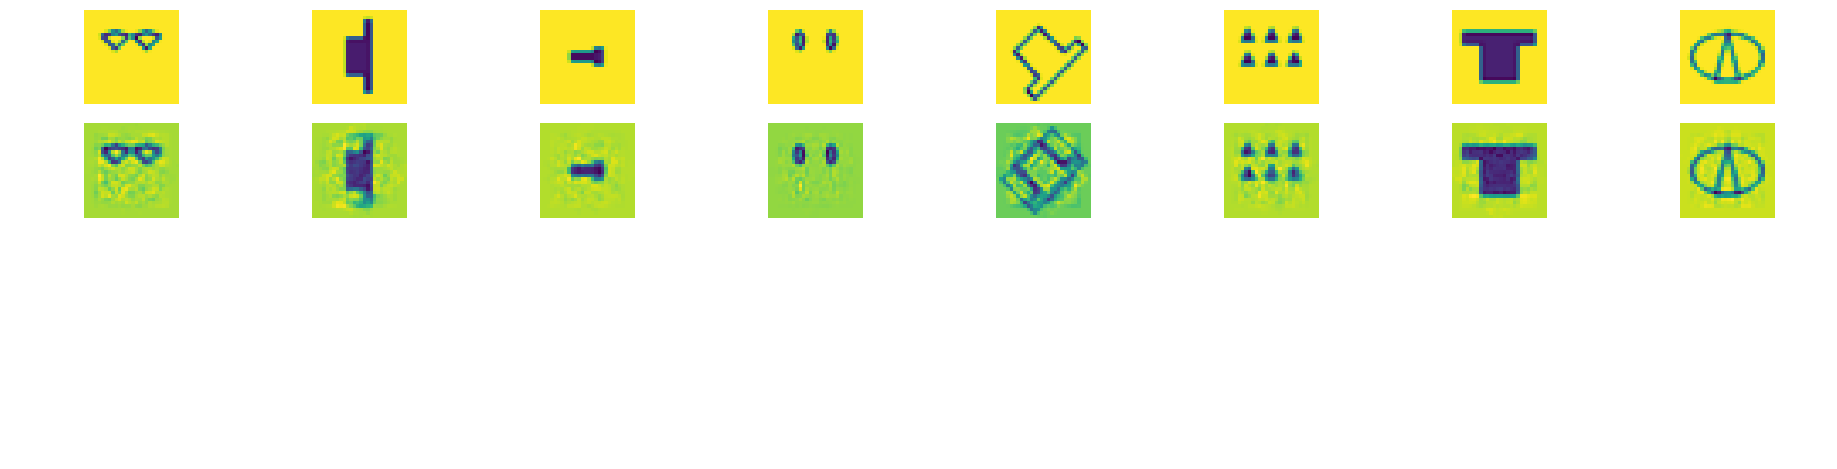

In [53]:
from src.utils import show_batch_of_images
show_batch_of_images(np.concatenate([data_np, output_np]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))

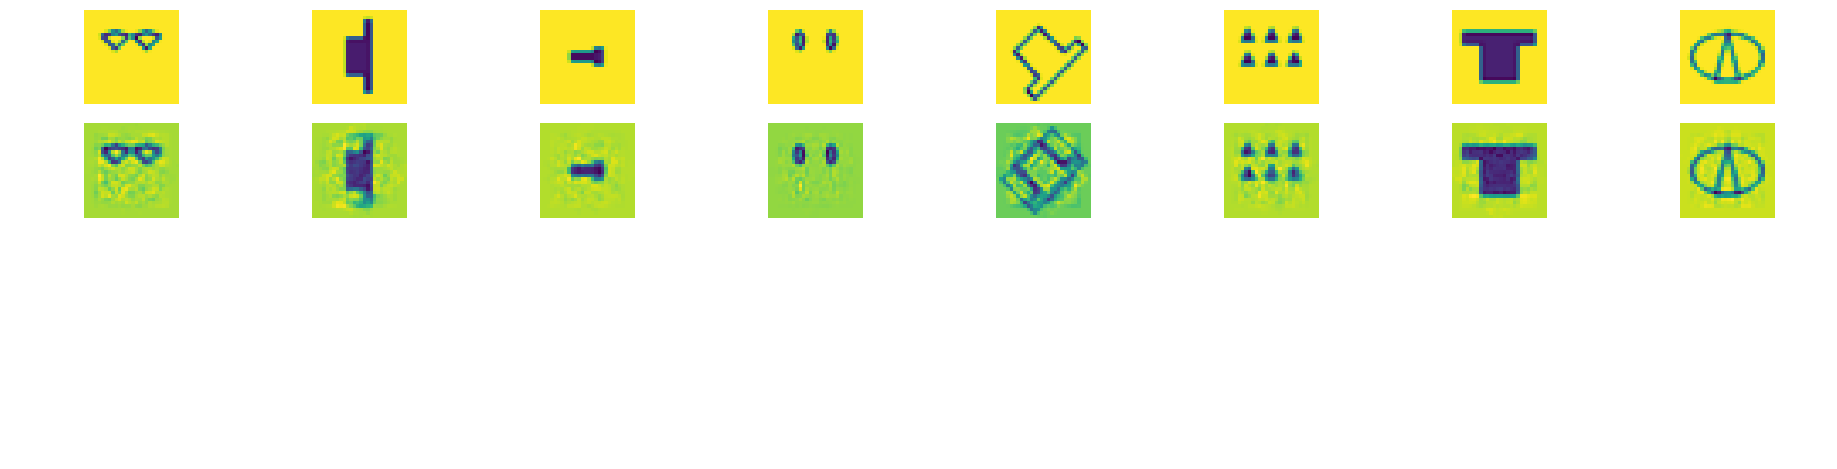

In [54]:
from src.utils import show_batch_of_images
show_batch_of_images(np.concatenate([data_np, output_np]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))

In [55]:
autoencoder.set_frozen(True)

### Train rest of architecture

In [56]:
optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr=lr, momentum=momentum)

In [57]:
import src
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test)

<module 'src.train_test' from '/home/miro/AI/mlp2/mlp-03/src/train_test.py'>

In [58]:
from src.train_test import train, test

epochs = 30
train(model, optimizer, train_data, val_data, use_cuda, train_batch_size, epochs)
test(model, optimizer, test_data, use_cuda, test_batch_size, ['3_layer'])

Train: Epoch: 1 Loss: 2.082975
Validation: Epoch: 1 Loss: 1.504222
Train: Epoch: 2 Loss: 1.698582
Validation: Epoch: 2 Loss: 1.462289
Train: Epoch: 3 Loss: 1.808954
Validation: Epoch: 3 Loss: 1.308647
Train: Epoch: 4 Loss: 1.608524
Validation: Epoch: 4 Loss: 1.759951
Train: Epoch: 5 Loss: 1.655221
Validation: Epoch: 5 Loss: 1.449268
Train: Epoch: 6 Loss: 1.578844
Validation: Epoch: 6 Loss: 1.500027
Train: Epoch: 7 Loss: 1.990070
Validation: Epoch: 7 Loss: 1.488387
Train: Epoch: 8 Loss: 1.174934
Validation: Epoch: 8 Loss: 1.409245
Train: Epoch: 9 Loss: 1.165584
Validation: Epoch: 9 Loss: 1.568018
Train: Epoch: 10 Loss: 1.358507
Validation: Epoch: 10 Loss: 1.986640
Train: Epoch: 11 Loss: 1.360278
Validation: Epoch: 11 Loss: 1.895380
Train: Epoch: 12 Loss: 1.236561
Validation: Epoch: 12 Loss: 1.811191
Train: Epoch: 13 Loss: 1.290737
Validation: Epoch: 13 Loss: 1.284173
Train: Epoch: 14 Loss: 1.269380
Validation: Epoch: 14 Loss: 1.492935
Train: Epoch: 15 Loss: 0.989759
Validation: Epoch: 1

In [59]:
from src.utils import make_vars
test_loader = test_data.get_batch_iterator(test_batch_size, transpose_inputs=True, separate_inputs=True)

(q_vectors, a_vectors), labels = next(test_loader)
q_vectors, a_vectors, labels = make_vars([q_vectors, a_vectors, labels], ['float', 'float', 'long'], use_cuda=use_cuda)
_, latent_prediction, decoded_q_vectors, _ = model(q_vectors, a_vectors)

In [60]:
targets = a_vectors

indices = torch.from_numpy(np.arange(8)).long()
if use_cuda:
    indices = indices.cuda()
targets = targets[indices, labels.data].squeeze()

In [61]:
# When differentiable AE
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size, 1, 1)).squeeze()

ValueError: shapes (8,100,1,1) and (100,784) not aligned: 1 (dim 3) != 100 (dim 0)

In [62]:
# When PCA
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(test_batch_size, 28, 28)

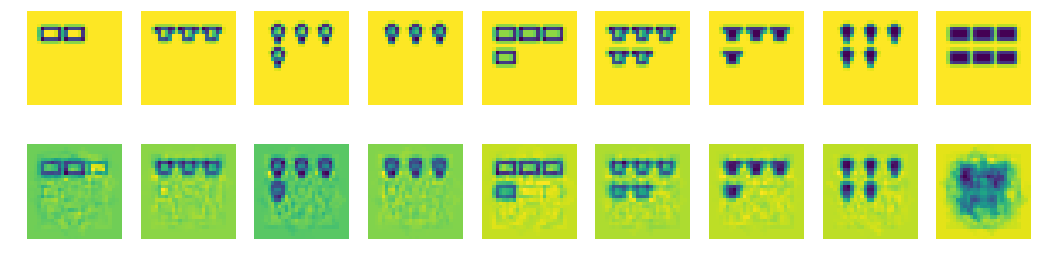

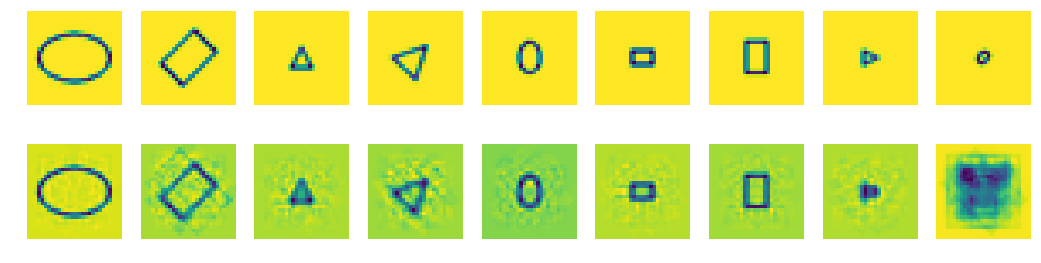

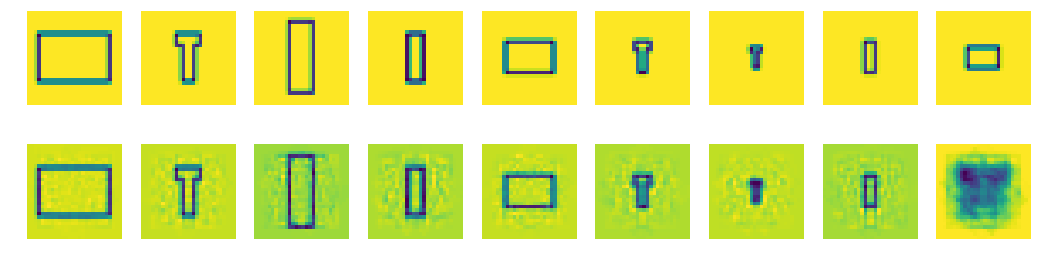

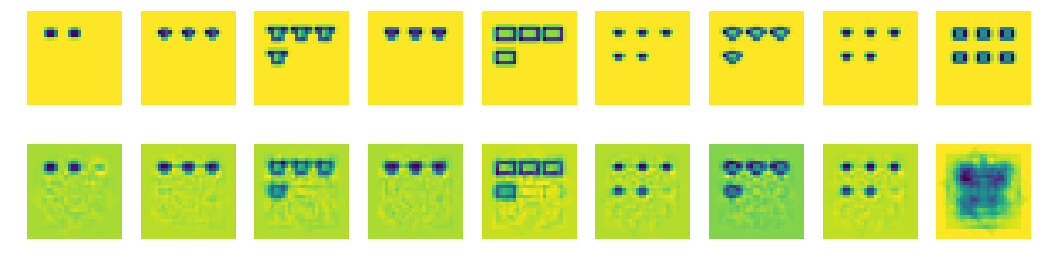

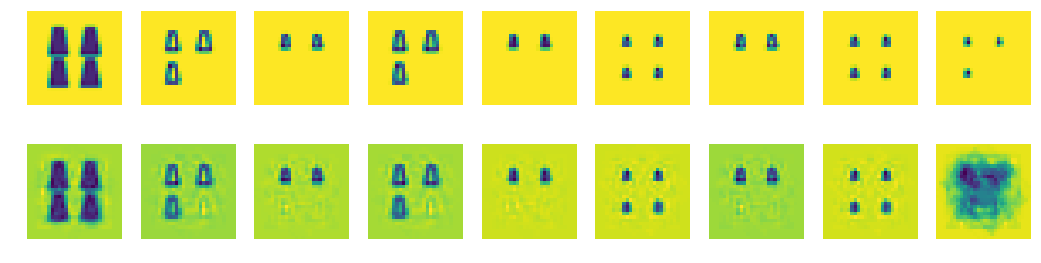

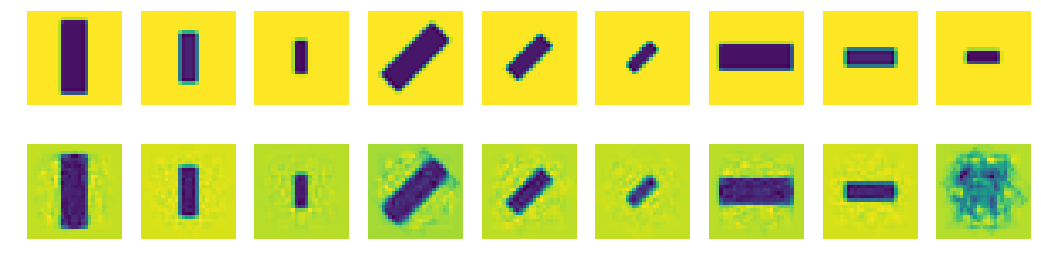

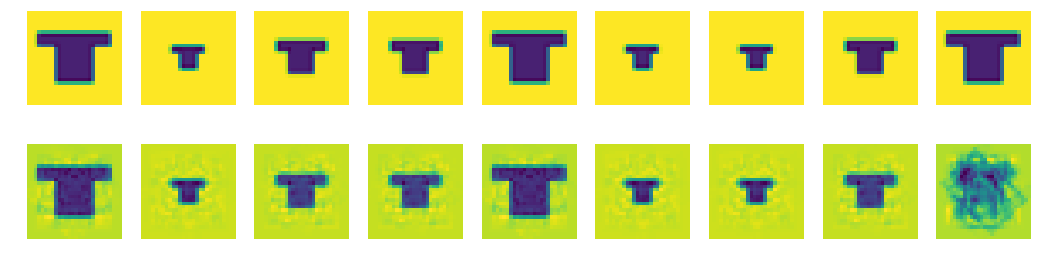

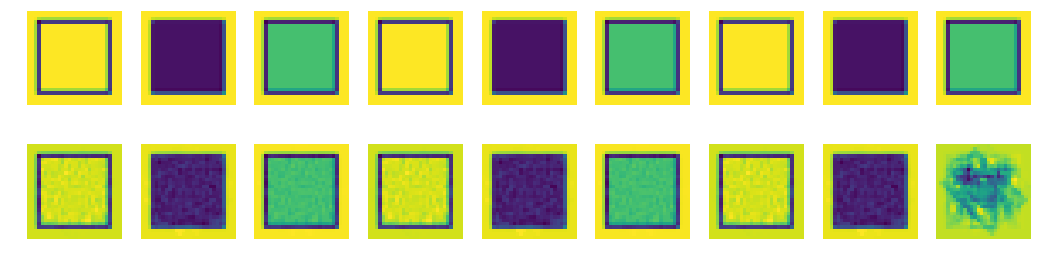

In [63]:
from src.utils import show_matrix
show_matrix(q_vectors, targets, decoded_q_vectors, decoded_prediction)